# Geolocation Matching

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from math import cos, sin, asin

pd.set_option('display.max_colwidth', -1)
plt.rcParams['figure.figsize'] = (15, 6)

%matplotlib inline

In [2]:
EARTH_RADIUS = 6371 * 1000  # meters

def get_haversine_distance(lat_1, lat_2, lon_1, lon_2):
    """Find the distance between `(lat_1, lon_1)` and `(lat_2, lon_2)`.
    """
    lat_1_rad, lon_1_rad = map(np.radians, [lat_1, lon_1])
    lat_2_rad, lon_2_rad = map(np.radians, [lat_2, lon_2])
    delta_lon = lon_2_rad - lon_1_rad
    delta_lat = lat_2_rad - lat_1_rad
    # Next two lines is the Haversine formula
    inverse_angle = (np.sin(delta_lat / 2) ** 2 +
                     np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(delta_lon / 2) ** 2)
    haversine_angle = 2 * np.arcsin(np.sqrt(inverse_angle))
    return haversine_angle * EARTH_RADIUS

## Data ingestion

In [3]:
country_code = 'AR'

**Cleaned operator data**

In [4]:
keep_columns = {'Client- Outlet Name': 'client-outlet_name_ohub',
                'Address': 'address_ohub',
                'Number': 'number_ohub',
                'Latitude': 'lat_ohub',
                'Longitude': 'lng_ohub'}

opr_geo = pd.read_csv('../../data/Phase_I/Phase_I_Input/AR_geolocation_clean.csv', sep=';', usecols=keep_columns.keys())
opr_geo.rename(columns=keep_columns, inplace=True)

print(opr_geo.shape)
opr_geo.head()

(11915, 5)


,client-outlet_name_ohub,address_ohub,number_ohub,lat_ohub,lng_ohub
0,CAICEDO MIRIAN,Francisco alvarez,2395.0,-32.917274,-68.832624
1,CATERBETTI FRANCO,Mendoza,2299.0,-34.560356,-58.456450
2,MAURE FERNANDO MARTIN,Pueyrredón,835.0,-32.908683,-68.826213
3,PULGAR PAOLA ROSANA,Tucuman,1161.0,-39.027775,-67.580741
4,LUPPI RICARDO NORBERTO SALVADOR,Avenida Córdoba,3249.0,-34.597641,-58.412588


**Google places data**

In [5]:
keep_columns = {'inputCountry': 'inputCountry',
                'outputCountry': 'country_google',
                'formattedAddress': 'address_google',
                'name': 'name_google',
                'lat': 'lat_google',
                'lng': 'lng_google',
                'placeId': 'placeId'}

opr_google = pd.read_csv('../../data/Phase_II/Phase_II_Output/OPR_ids_details.csv', sep=',', usecols=keep_columns.keys())
opr_google.rename(columns=keep_columns, inplace=True)
opr_google = opr_google.loc[opr_google.inputCountry == country_code].drop_duplicates(subset=['placeId'])
print(opr_google.shape)
opr_google.sample(10)

(71414, 7)


,address_google,inputCountry,lat_google,lng_google,name_google,country_google,placeId
24390,"Av. Corrientes 5800, C1414AJX CABA, Argentina",AR,-34.594999,-58.444335,Subway,Argentina,ChIJOYPskvW1vJUR-p-nwiPT924
34062,"C1414DDD, Thames 1472, C1414DDD CABA, Argentina",AR,-34.588854,-58.432581,Parque Bar Botanico,Argentina,ChIJ_cYUEYm1vJURKy0TAHzUOUs
75229,"Cevallos 769, Quilmes, Buenos Aires, Argentina",AR,-34.718923,-58.244725,Escuela de Educación Especial N°502,Argentina,ChIJeTZfQkguo5URYQJ8_QHUMaI
19368,"Buenos Aires, Argentina",AR,-34.587681,-58.389061,L'orangerie-alvear Palace Hotel,Argentina,ChIJX2LsfKPKvJURyLHEl-GmUYE
13842,"Cerrito 1136, C1010AAX CABA, Argentina",AR,-34.595064,-58.382946,Ctl SA,Argentina,ChIJlwm0frfKvJURA1-iM4SfJwE
22034,"Av. Francisco Piovano 5900, La Reja, Buenos Aires, Argentina",AR,-34.639132,-58.831375,"PARRILLA""EL VASCO""",Argentina,ChIJTyhzWvaTvJURQHTYzb8DI10
74540,"B1722ISP, Aráoz 740, B1722ISP San Antonio de Padua, Provincia de Buenos Aires, Argentina",AR,-34.659971,-58.711742,Instituto Secundario Manuel Belgrano,Argentina,ChIJTyJa-JK_vJUROAYSyhXT0s8
34531,"Avinada de la Unión 1825, Pontevedra, Buenos Aires, Argentina",AR,-34.747540,-58.699321,La Cantera Bar y Padel,Argentina,ChIJrdGZb4fBvJURP_lWmuTK8N8
64621,"Calle 49 1395, Casco Urbano, B1900ARC La Plata, Buenos Aires, Argentina",AR,-34.928623,-57.966774,Escuela No. 126 Dr. Francisco Latrubesse,Argentina,ChIJL0XH-dPnopURpqurzQlAcBk
11747,"Gral. César Díaz 5301, C1407EUO CABA, Argentina",AR,-34.631457,-58.502254,La Esquina,Argentina,ChIJjSf678nJvJUR2U3cXByYdB0


## Match using latitude and longitude

In [6]:
opr_geo.dtypes

client-outlet_name_ohub    object 
address_ohub               object 
number_ohub                float64
lat_ohub                   float64
lng_ohub                   float64
dtype: object

In [7]:
opr_google.dtypes

address_google    object 
inputCountry      object 
lat_google        float64
lng_google        float64
name_google       object 
country_google    object 
placeId           object 
dtype: object

**Retrieve closest observation based on geolocation**

In [8]:
def match_geolocations(row, keep_columns=None):
    keep_columns = keep_columns or ['lat_google', 'lng_google', 'address_google', 'country_google', 'name_google', 'placeId']
    
    diff = get_haversine_distance(row.lat_ohub, opr_google.lat_google, row.lng_ohub, opr_google.lng_google)
    index = diff.idxmin()
    row = row.append(opr_google.loc[index, keep_columns])
    row['diff_meters'] = diff[index]
    return row

In [9]:
opr_matches = opr_geo.apply(match_geolocations, axis=1)

In [10]:
opr_matches.number_ohub = opr_matches.number_ohub.fillna(-1).astype(int).astype(str)

In [11]:
opr_matches = opr_matches[['client-outlet_name_ohub', 'name_google', 'address_ohub', 'number_ohub', 'address_google', 'country_google', 'lat_ohub', 'lat_google', 'lng_ohub', 'lng_google', 'diff_meters', 'placeId']].sort_values('diff_meters')
opr_matches.sample(20)

,client-outlet_name_ohub,name_google,address_ohub,number_ohub,address_google,country_google,lat_ohub,lat_google,lng_ohub,lng_google,diff_meters,placeId
2722,RAJNERI RAUL,Esc primaria 44,Santa Cruz,1136,"Buenos Aires Province, Argentina",Argentina,-39.031310,-38.670148,-67.583482,-62.456998,445689.153064,ChIJKdqzpATI7ZURTPJCajbRuvY
10526,FERNANDEZ EUGENIO,Esc primaria 56,Dique Guillermo Cespedes,1683,"Paraje La Hormiga,, Bahía Blanca, Buenos Aires, Argentina",Argentina,-32.935445,-38.595183,-68.863847,-62.386687,858345.065946,ChIJR08-2pC27ZUR0S0axEq4D8Y
8816,GOURMET S.R.L,Finca Oliva Olivos,Avenida Belgrano,638,"RN 3 Vieja, Bahía Blanca, Buenos Aires, Argentina",Argentina,-38.372014,-38.710692,-60.269807,-62.049221,159272.492506,ChIJ3fC7McAK7ZUR7vslpGCGrR4
7381,GARCIA ARMANDO(TOTI PARRILLA),Carniceria Colon (gallelo),Chile,235,"A. Schinoni 131, Campana, Buenos Aires, Argentina",Argentina,-32.406823,-34.209211,-63.242273,-58.935826,447513.998919,ChIJ10eCnM5xu5URqNQycpAKxdw
6263,RODRIGUEZ ALEJANDRA,Esc primaria 56,Zeballos,219,"Paraje La Hormiga,, Bahía Blanca, Buenos Aires, Argentina",Argentina,-32.922713,-38.595183,-68.835736,-62.386687,857695.555858,ChIJR08-2pC27ZUR0S0axEq4D8Y
7033,SE BIBLIOTECA S.R.L,Seven Eleven de la Biblioteca,25 de Mayo,387,"25 de Mayo 387, B1642CJG San Isidro, Buenos Aires, Argentina",Argentina,-34.468309,-34.468313,-58.510311,-58.510275,3.330082,ChIJg6OtFTOwvJURgaimw29WB4U
5564,Z8 SRL (HOTEL LOS ESPINILLOS),Carniceria Colon (gallelo),Pavón,50,"A. Schinoni 131, Campana, Buenos Aires, Argentina",Argentina,-31.423137,-34.209211,-64.505029,-58.935826,605516.372682,ChIJ10eCnM5xu5URqNQycpAKxdw
462,CONTRERAS ORELLANAS MAURICIO ANDRES,Esc primaria 56,Avenida Mitre,2229,"Paraje La Hormiga,, Bahía Blanca, Buenos Aires, Argentina",Argentina,-32.878297,-38.595183,-68.812811,-62.386687,860044.718662,ChIJR08-2pC27ZUR0S0axEq4D8Y
6215,ACOSTA EDUARDO MARCELO,Carniceria Colon (gallelo),Bahia Blanca,355,"A. Schinoni 131, Campana, Buenos Aires, Argentina",Argentina,-31.417404,-34.209211,-64.169978,-58.935826,579204.805688,ChIJ10eCnM5xu5URqNQycpAKxdw
9027,ZZZPEREYRA GUILLERMO ALCIDES,Jardin 918,Castelli,3519,"Ventura Cintas 1648, Campana, Buenos Aires, Argentina",Argentina,-31.679766,-34.203396,-60.768282,-58.928137,328968.356910,ChIJwRR3lNBxu5URG_yxuyvHjV0


Ohub number in google addres

In [12]:
opr_matches['match_number'] = opr_matches.apply(lambda x: x.number_ohub in x.address_google, axis=1)

### Summary

**Raw output matching data**

In [13]:
opr_matches.diff_meters.describe()

count    1.191500e+04
mean     4.609971e+05
std      3.551127e+05
min      0.000000e+00
25%      9.111190e+01
50%      4.456240e+05
75%      8.544284e+05
max      1.519136e+06
Name: diff_meters, dtype: float64

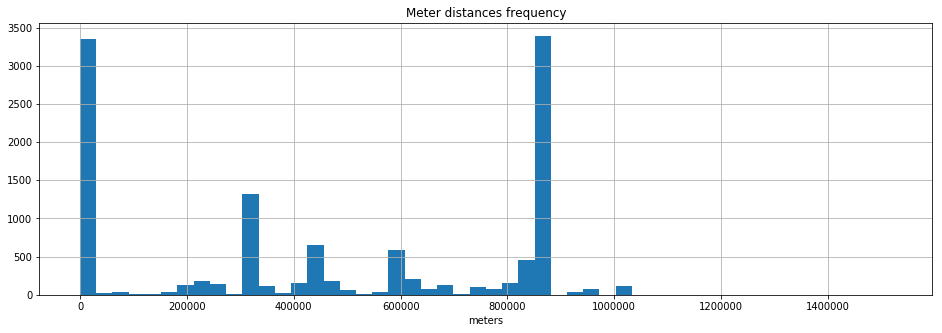

In [14]:
opr_matches.hist(column='diff_meters', figsize=(16, 5), bins=50)
plt.xlabel('meters')
plt.title('Meter distances frequency');

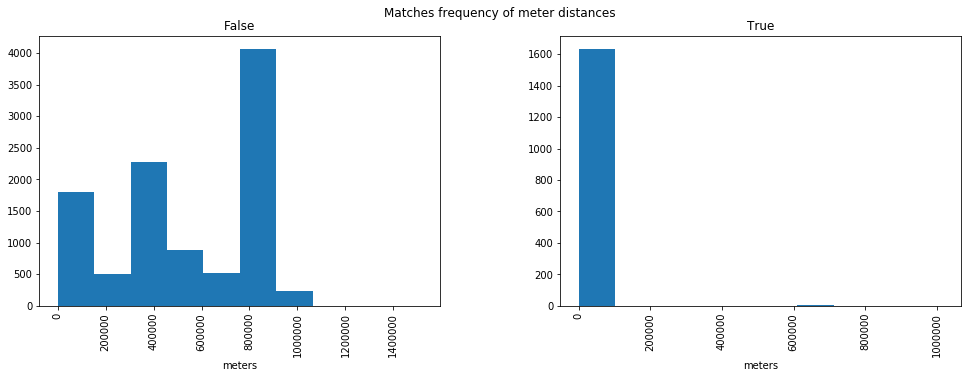

In [15]:
# separate: if ohub number is in the google address
ax = opr_matches.hist(column='diff_meters', by='match_number', figsize=(16, 5), bins=10)
ax[0].set_xlabel('meters'), ax[1].set_xlabel('meters')
plt.suptitle('Matches frequency of meter distances');

In [16]:
opr_matches[~opr_matches.match_number].sort_values(by='diff_meters', ascending=True).head(100)

,client-outlet_name_ohub,name_google,address_ohub,number_ohub,address_google,country_google,lat_ohub,lat_google,lng_ohub,lng_google,diff_meters,placeId,match_number
5957,ESPINOZA ROJAS LUCINDA TEODORA,Miriam,Ibarrola,7186,"Planta Baja, Ibarrola 7184, C1408DXR CABA, Argentina",Argentina,-34.641710,-34.641710,-58.527130,-58.527130,0.000000e+00,ChIJIWkT4EDIvJURJYHCbIHNm7M,False
2852,HOTELES DEL PLATA SA DE HOT. Y TUR.,Maria Pepe,Libertad,1020,"Libertad 1027, C1012AAU CABA, Argentina",Argentina,-34.596599,-34.596599,-58.384459,-58.384459,0.000000e+00,ChIJg7nYO7jKvJURfqJ0gu7w3qE,False
1188,REYES LOLIN LORENZO,Miriam,Ibarrola,7186,"Planta Baja, Ibarrola 7184, C1408DXR CABA, Argentina",Argentina,-34.641710,-34.641710,-58.527130,-58.527130,0.000000e+00,ChIJIWkT4EDIvJURJYHCbIHNm7M,False
2729,BENEDIT SRL,Colegio San Jose,Avenida Córdoba,815,"Edificio Bencich, C1057 CABA, Argentina",Argentina,-34.598676,-34.598676,-58.378535,-58.378535,0.000000e+00,ChIJCcJrmcnKvJURTjvYBQrLl40,False
11428,SERVICIOS COMPASS DE ARGENTINA SA,NOCHE VERDE PUB,Avenida Constituyentes,3780,"Av. Constituyentes 5892, Gral. Pacheco, Buenos Aires, Argentina",Argentina,-34.446595,-34.446595,-58.675831,-58.675831,0.000000e+00,ChIJwWn6XbmjvJURKsB9vbdenhk,False
1848,CAFE COMEGA S.R.L.,Estancia La Candelaria,Avenida Corrientes,224,"Av. Corrientes 222, C1043AAP CABA, Argentina",Argentina,-34.603237,-34.603237,-58.370665,-58.370665,0.000000e+00,ChIJvQxYQmQHvZURirCqOSX0FVg,False
11742,MAZZIERI IVAN LEONEL,Sláinte Irish Pub,Avenida San Martin,6080,"Av. San Martín 6066, Buenos Aires, Argentina",Argentina,-34.595371,-34.595371,-58.501610,-58.501610,0.000000e+00,ChIJC2Ie7Ta2vJURBKL8fl_40ms,False
11738,SERVICIOS COMPASS DE ARGENTINA S.A.,NOCHE VERDE PUB,Avenida Constituyentes,3780,"Av. Constituyentes 5892, Gral. Pacheco, Buenos Aires, Argentina",Argentina,-34.446595,-34.446595,-58.675831,-58.675831,0.000000e+00,ChIJwWn6XbmjvJURKsB9vbdenhk,False
11697,SERVICIOS COMPASS DE ARGENTINA SA,NOCHE VERDE PUB,Avenida Constituyentes,3780,"Av. Constituyentes 5892, Gral. Pacheco, Buenos Aires, Argentina",Argentina,-34.446595,-34.446595,-58.675831,-58.675831,0.000000e+00,ChIJwWn6XbmjvJURKsB9vbdenhk,False
11212,SERVICIOS COMPASS DE ARGENTINA SA,NOCHE VERDE PUB,Avenida Constituyentes,3780,"Av. Constituyentes 5892, Gral. Pacheco, Buenos Aires, Argentina",Argentina,-34.446595,-34.446595,-58.675831,-58.675831,0.000000e+00,ChIJwWn6XbmjvJURKsB9vbdenhk,False


**Make cut-off of difference is more than 50 meters**

In [17]:
nearby_matches = opr_matches[opr_matches.diff_meters < 4000]
print('Total maches:\t', opr_matches.shape[0])
print('Nearby matches (< 100 meters):\t', nearby_matches.shape[0])
print('Percentage:\t', round(100 * nearby_matches.shape[0] / opr_matches.shape[0], 2))

Total maches:	 11915
Nearby matches (< 100 meters):	 3345
Percentage:	 28.07


In [18]:
nearby_matches.diff_meters.describe()

count    3345.000000
mean     33.240939  
std      78.184021  
min      0.000000   
25%      1.805287   
50%      9.718626   
75%      28.170821  
max      1498.594571
Name: diff_meters, dtype: float64

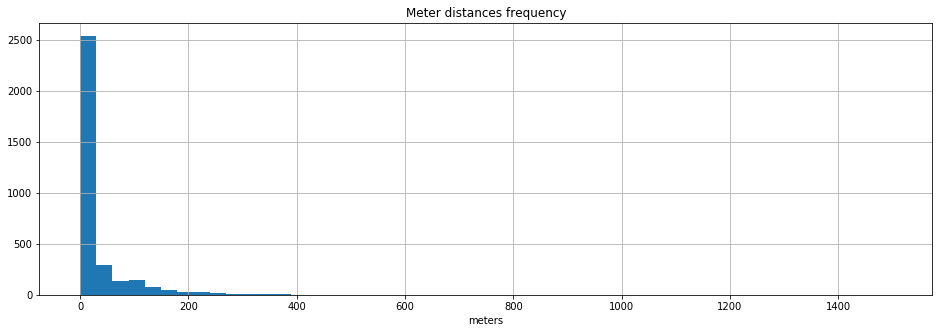

In [19]:
ax = nearby_matches.hist(column='diff_meters', figsize=(16, 5), bins=50)
plt.xlabel('meters')
plt.title('Meter distances frequency');

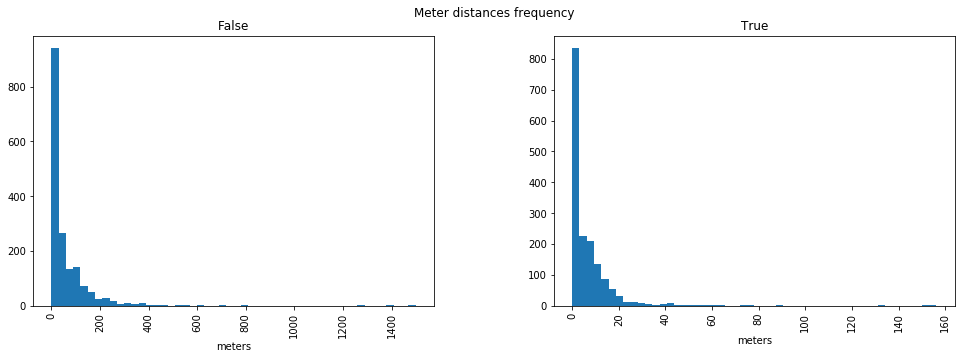

In [20]:
# separate: if ohub number is in the google address
ax = nearby_matches.hist(column='diff_meters', by='match_number', figsize=(16, 5), bins=50)
ax[0].set_xlabel('meters'), ax[1].set_xlabel('meters')
plt.suptitle('Meter distances frequency');

dump as csv

In [21]:
opr_matches.sort_values(by='diff_meters', ascending=True).to_csv('AR_geolocation_matches.csv', header=True, index=False)